In [1]:
# !pip uninstall tensorflow tensorflow-tensorboard tensorflow-estimator
!pip install gdown
!pip install tensorflow-gpu

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [7]:
df = pd.read_csv(
  "/home/jovyan/work/training_data/rf_msw_mal_mhr_mal2_training_data.csv", 
  parse_dates=['read_date'], 
  index_col="read_date"
)

In [8]:
df = df.drop(['bl_meter1','mean_temp1','bl_meter2','mean_temp2','bl_meter3','mean_temp3','bl_meter4','mean_temp4','sl_meter','rf_meter'
             ],axis=1)

In [9]:
df.shape

(4654, 6)

In [10]:
df.head()

,sl_read1,bl_ahd1,bl_ahd2,bl_ahd3,bl_ahd4,rf_read1
read_date,,,,,,
2007-09-06,0.159,252.354,251.007,280.620,278.977,0.0
2007-09-07,0.155,252.352,251.014,280.617,278.980,0.0
2007-09-08,0.153,252.351,251.016,280.617,278.984,0.0
2007-09-09,0.154,252.349,251.013,280.611,278.979,0.0
2007-09-10,0.149,252.347,251.012,280.608,278.981,0.0


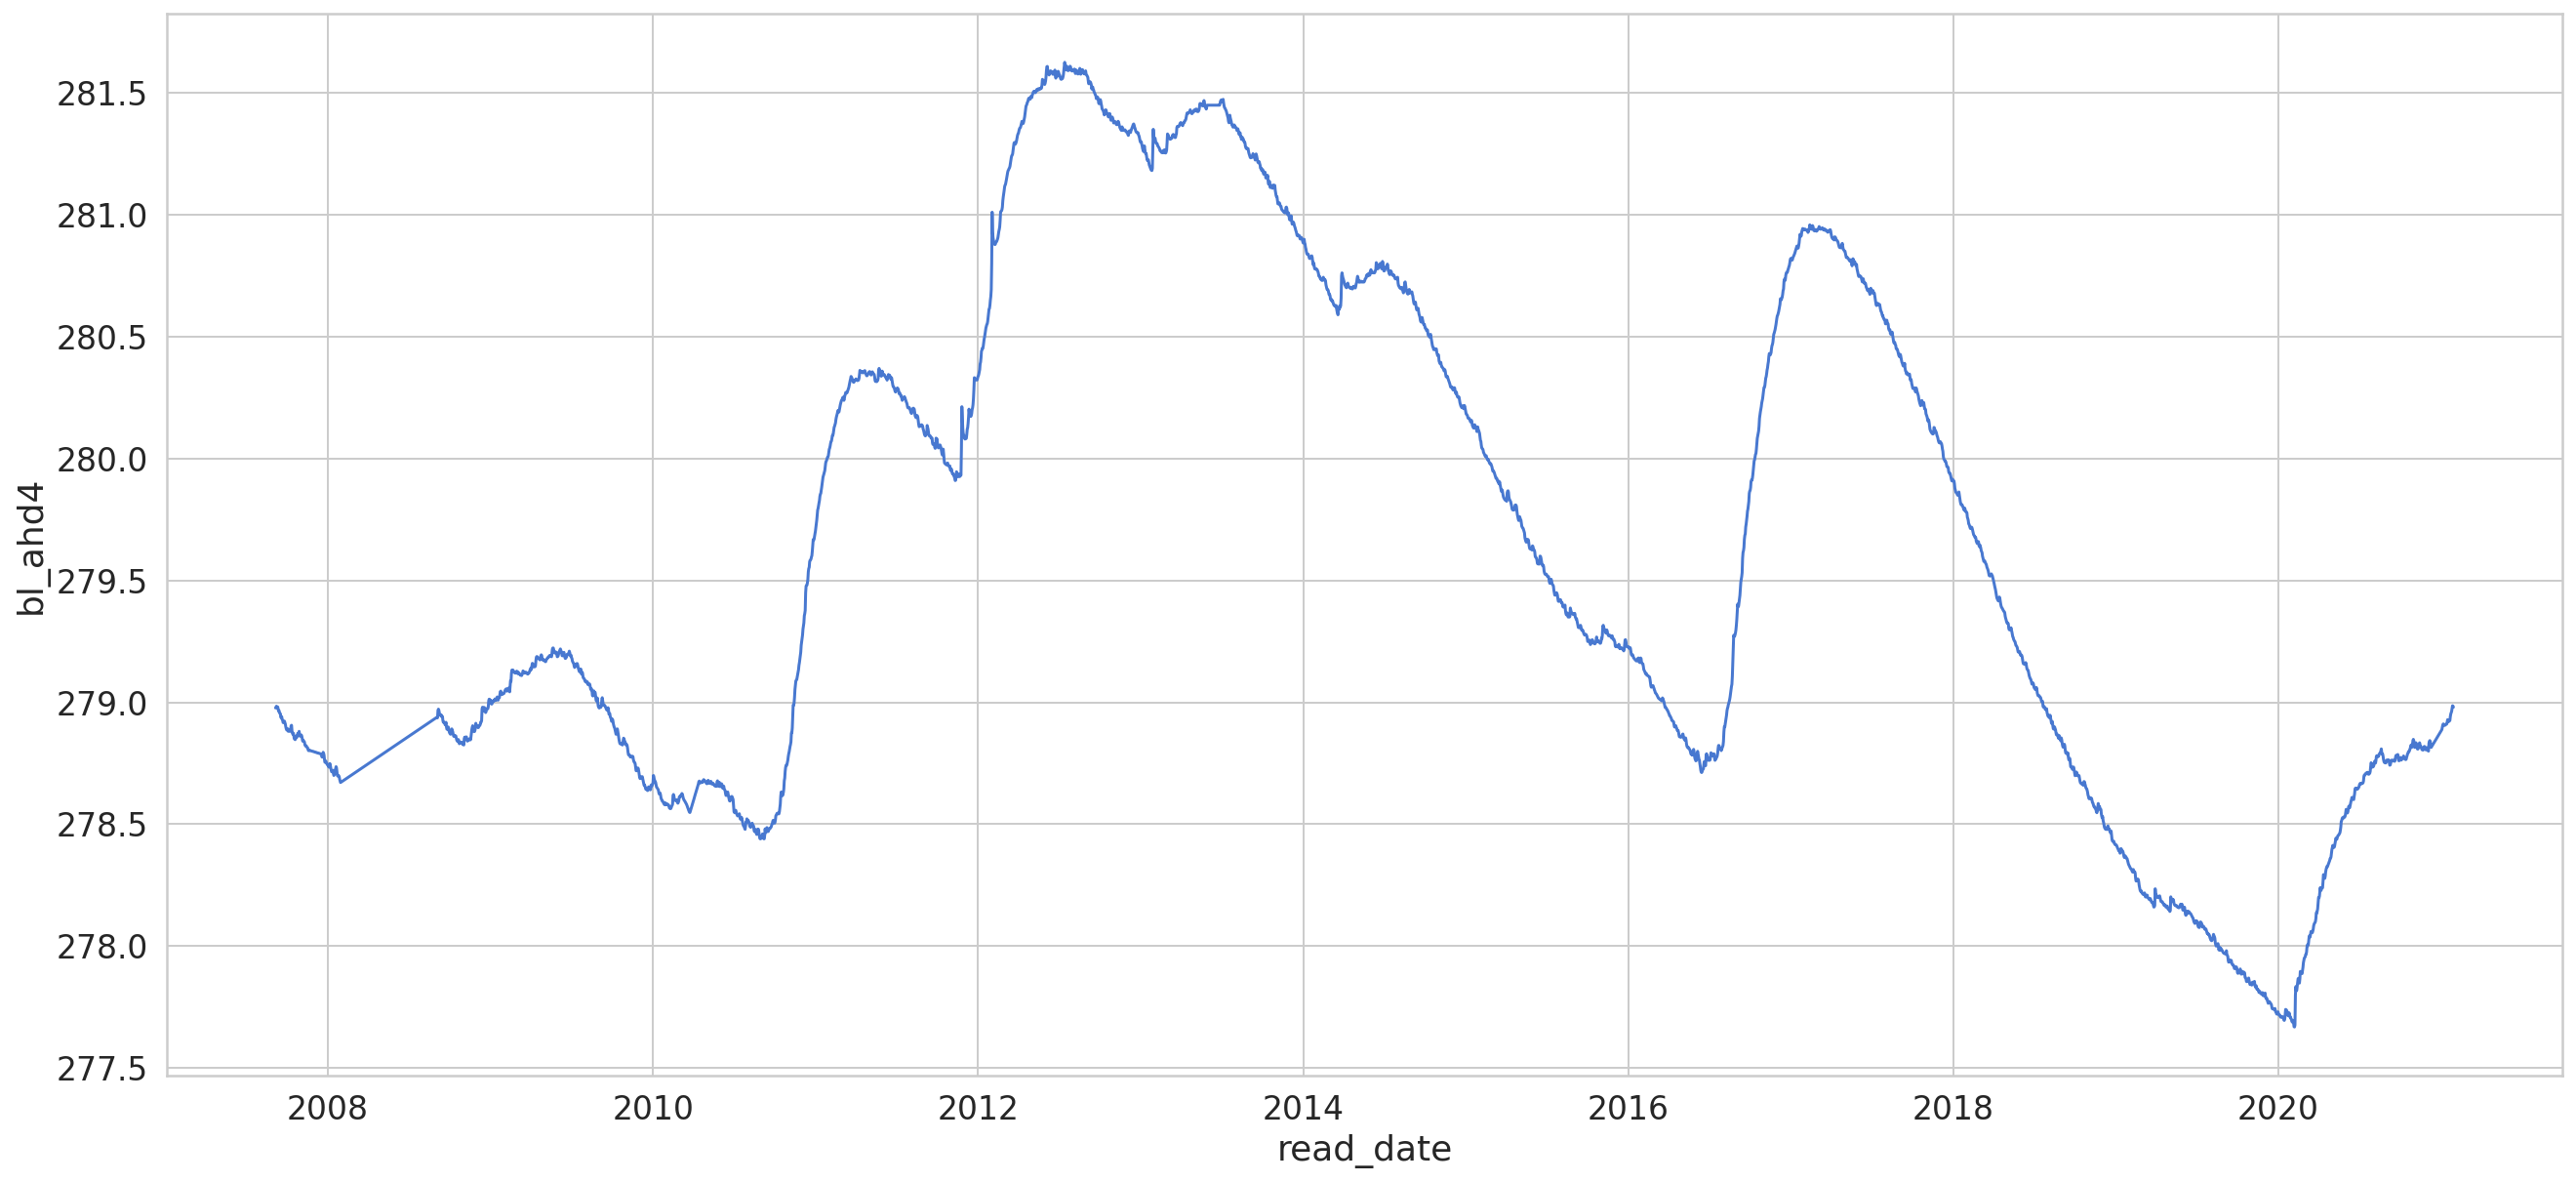

In [11]:
sns.lineplot(x=df.index, y="bl_ahd4", data=df);

In [12]:
train_size = int(len(df) * 0.75)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

3490 1164


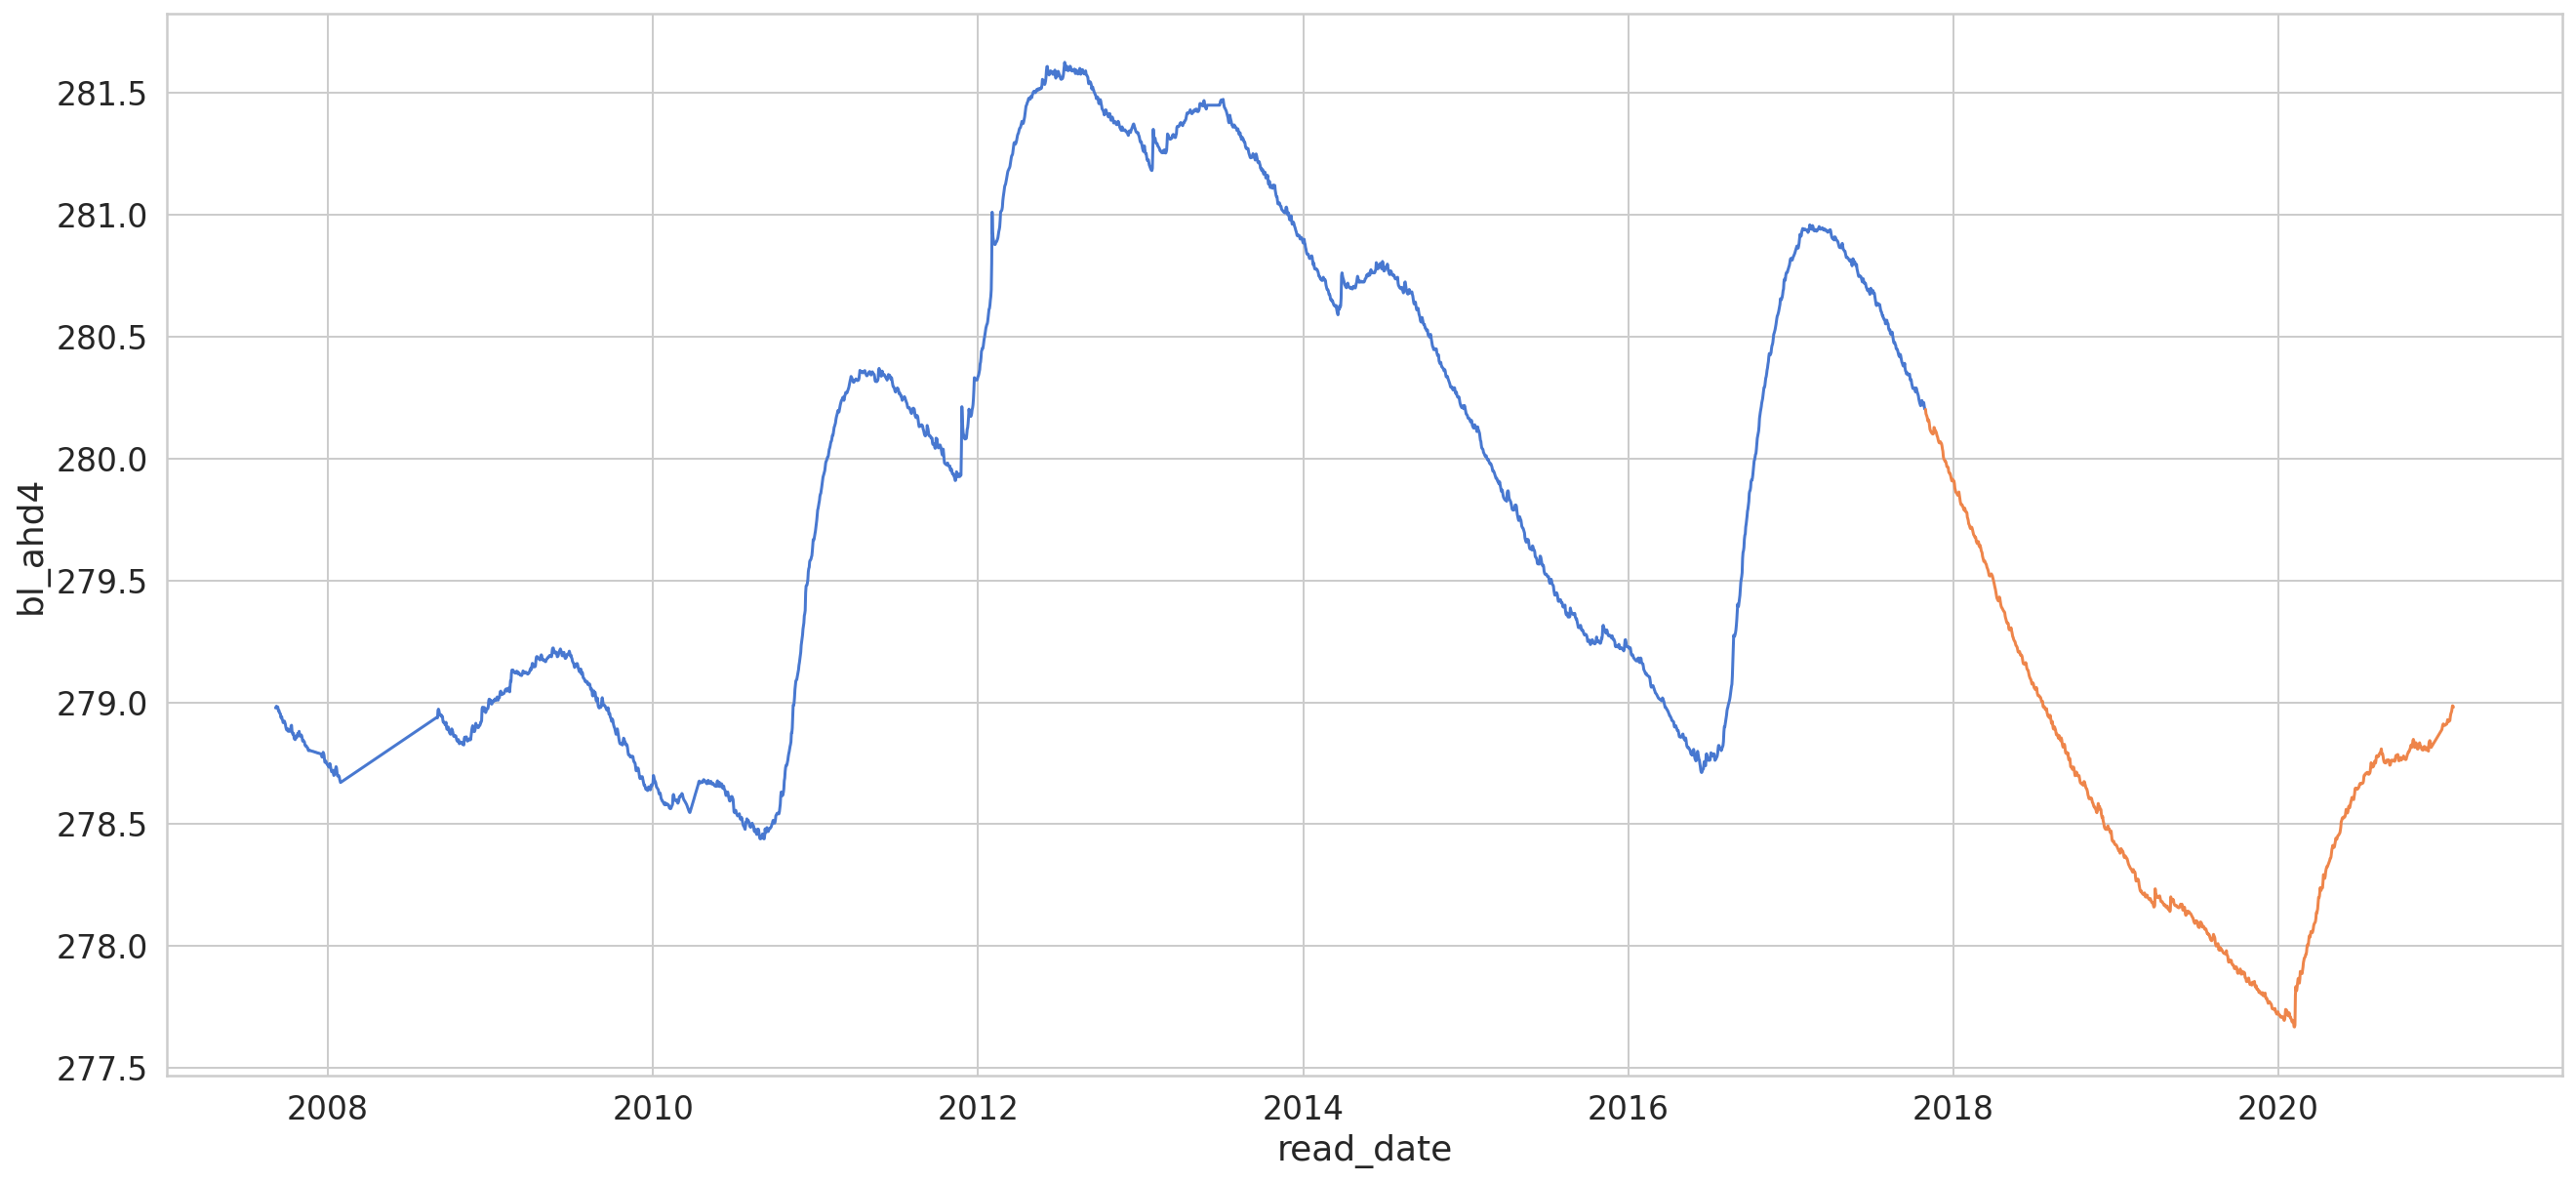

In [13]:
sns.lineplot(x=train.index, y="bl_ahd4", data=train);
sns.lineplot(x=test.index, y="bl_ahd4", data=test);

In [14]:
from sklearn.preprocessing import RobustScaler

#f_columns = ['t1', 't2', 'hum', 'wind_speed']
f_columns = ['rf_read1', 'sl_read1', 'bl_ahd1','bl_ahd2','bl_ahd3']

f_transformer = RobustScaler()
sl_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
sl_transformer = sl_transformer.fit(train[['bl_ahd4']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['bl_ahd4'] = sl_transformer.transform(train[['bl_ahd4']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['bl_ahd4'] = sl_transformer.transform(test[['bl_ahd4']])


#from sklearn.preprocessing import RobustScaler
#
#f_columns = ['t1', 't2', 'hum', 'wind_speed']
#
#f_transformer = RobustScaler()
#cnt_transformer = RobustScaler()
#
#f_transformer = f_transformer.fit(train[f_columns].to_numpy())
#cnt_transformer = cnt_transformer.fit(train[['cnt']])
#
#train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
#train['cnt'] = cnt_transformer.transform(train[['cnt']])
#
#test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
#test['cnt'] = cnt_transformer.transform(test[['cnt']])


/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-14-8b2b54c1ac1b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
<ipython-input-14-8b2b54c1ac1b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [15]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [16]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.bl_ahd1, time_steps)
X_test, y_test = create_dataset(test, test.bl_ahd1, time_steps)

print(X_train.shape, y_train.shape)

(3480, 10, 6) (3480,)


In [17]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [18]:
history = model.fit(
    X_train, y_train, 
    epochs=40, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/40
98/98 [==============================] - 5s 21ms/step - loss: 1.5594 - val_loss: 0.0680
Epoch 2/40
98/98 [==============================] - 1s 13ms/step - loss: 0.3112 - val_loss: 0.0651
Epoch 3/40
98/98 [==============================] - 1s 12ms/step - loss: 0.2389 - val_loss: 0.0723
Epoch 4/40
98/98 [==============================] - 1s 14ms/step - loss: 0.1974 - val_loss: 0.0616
Epoch 5/40
98/98 [==============================] - 1s 12ms/step - loss: 0.1686 - val_loss: 0.0410
Epoch 6/40
98/98 [==============================] - 1s 12ms/step - loss: 0.1509 - val_loss: 0.0246
Epoch 7/40
98/98 [==============================] - 1s 13ms/step - loss: 0.1761 - val_loss: 0.0161
Epoch 8/40
98/98 [==============================] - 1s 13ms/step - loss: 0.2042 - val_loss: 0.0222
Epoch 9/40
98/98 [==============================] - 1s 13ms/step - loss: 0.1692 - val_loss: 0.0228
Epoch 10/40
98/98 [==============================] - 1s 12ms/step - loss: 0.1364 - val_loss: 0.0209
Epoch 11/

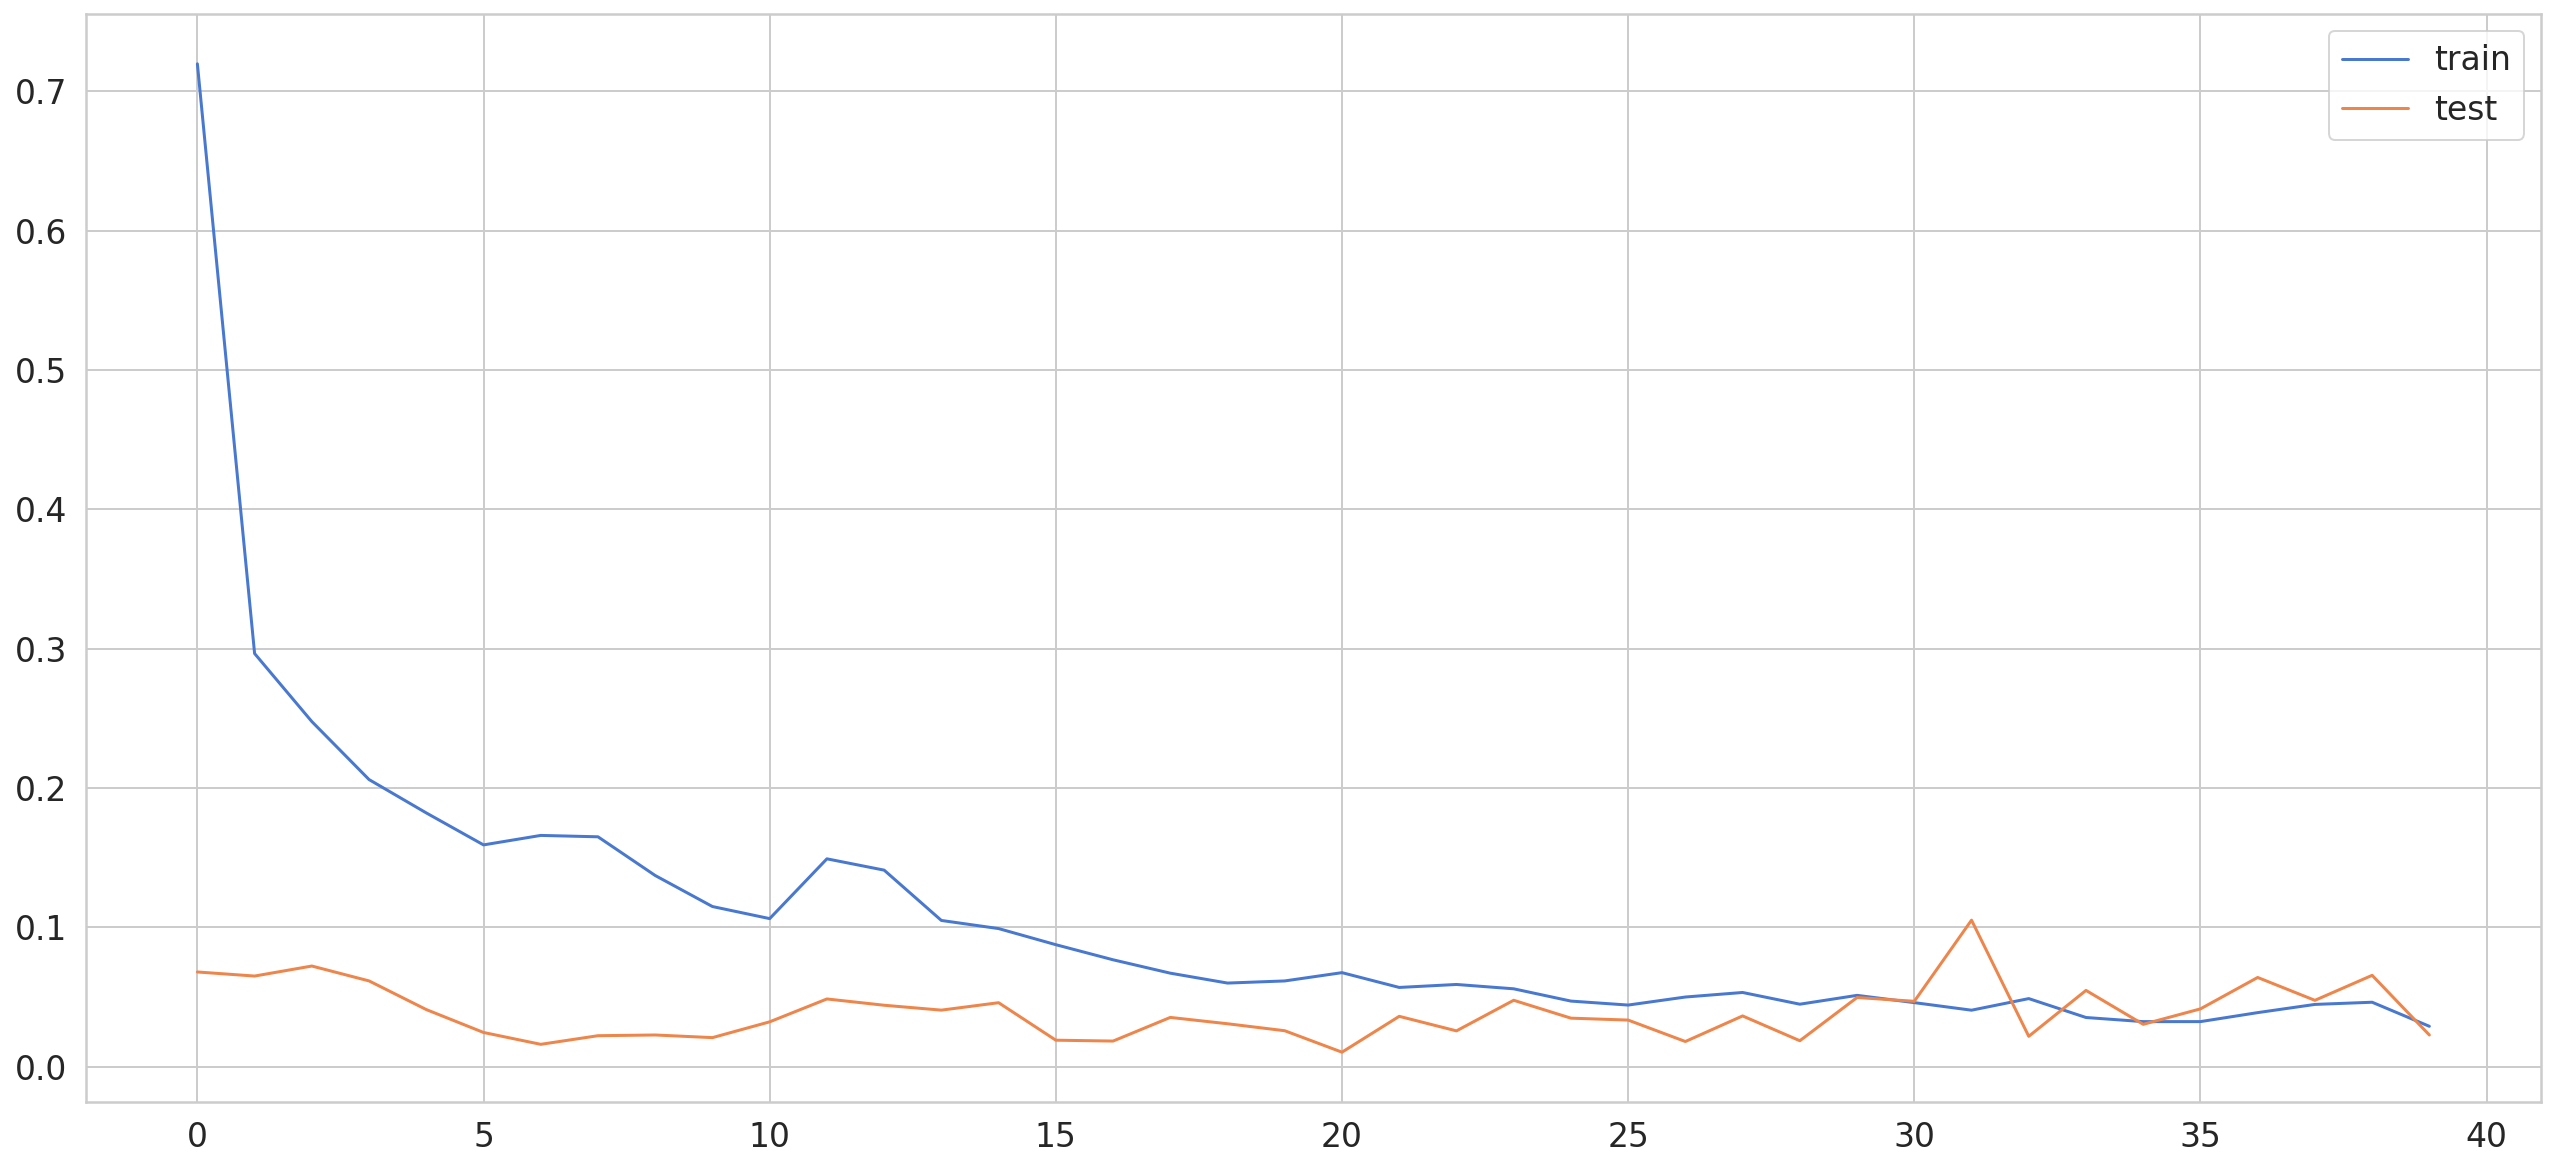

In [19]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [20]:
y_pred = model.predict(X_test)

In [21]:
y_train_inv = sl_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = sl_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = sl_transformer.inverse_transform(y_pred)

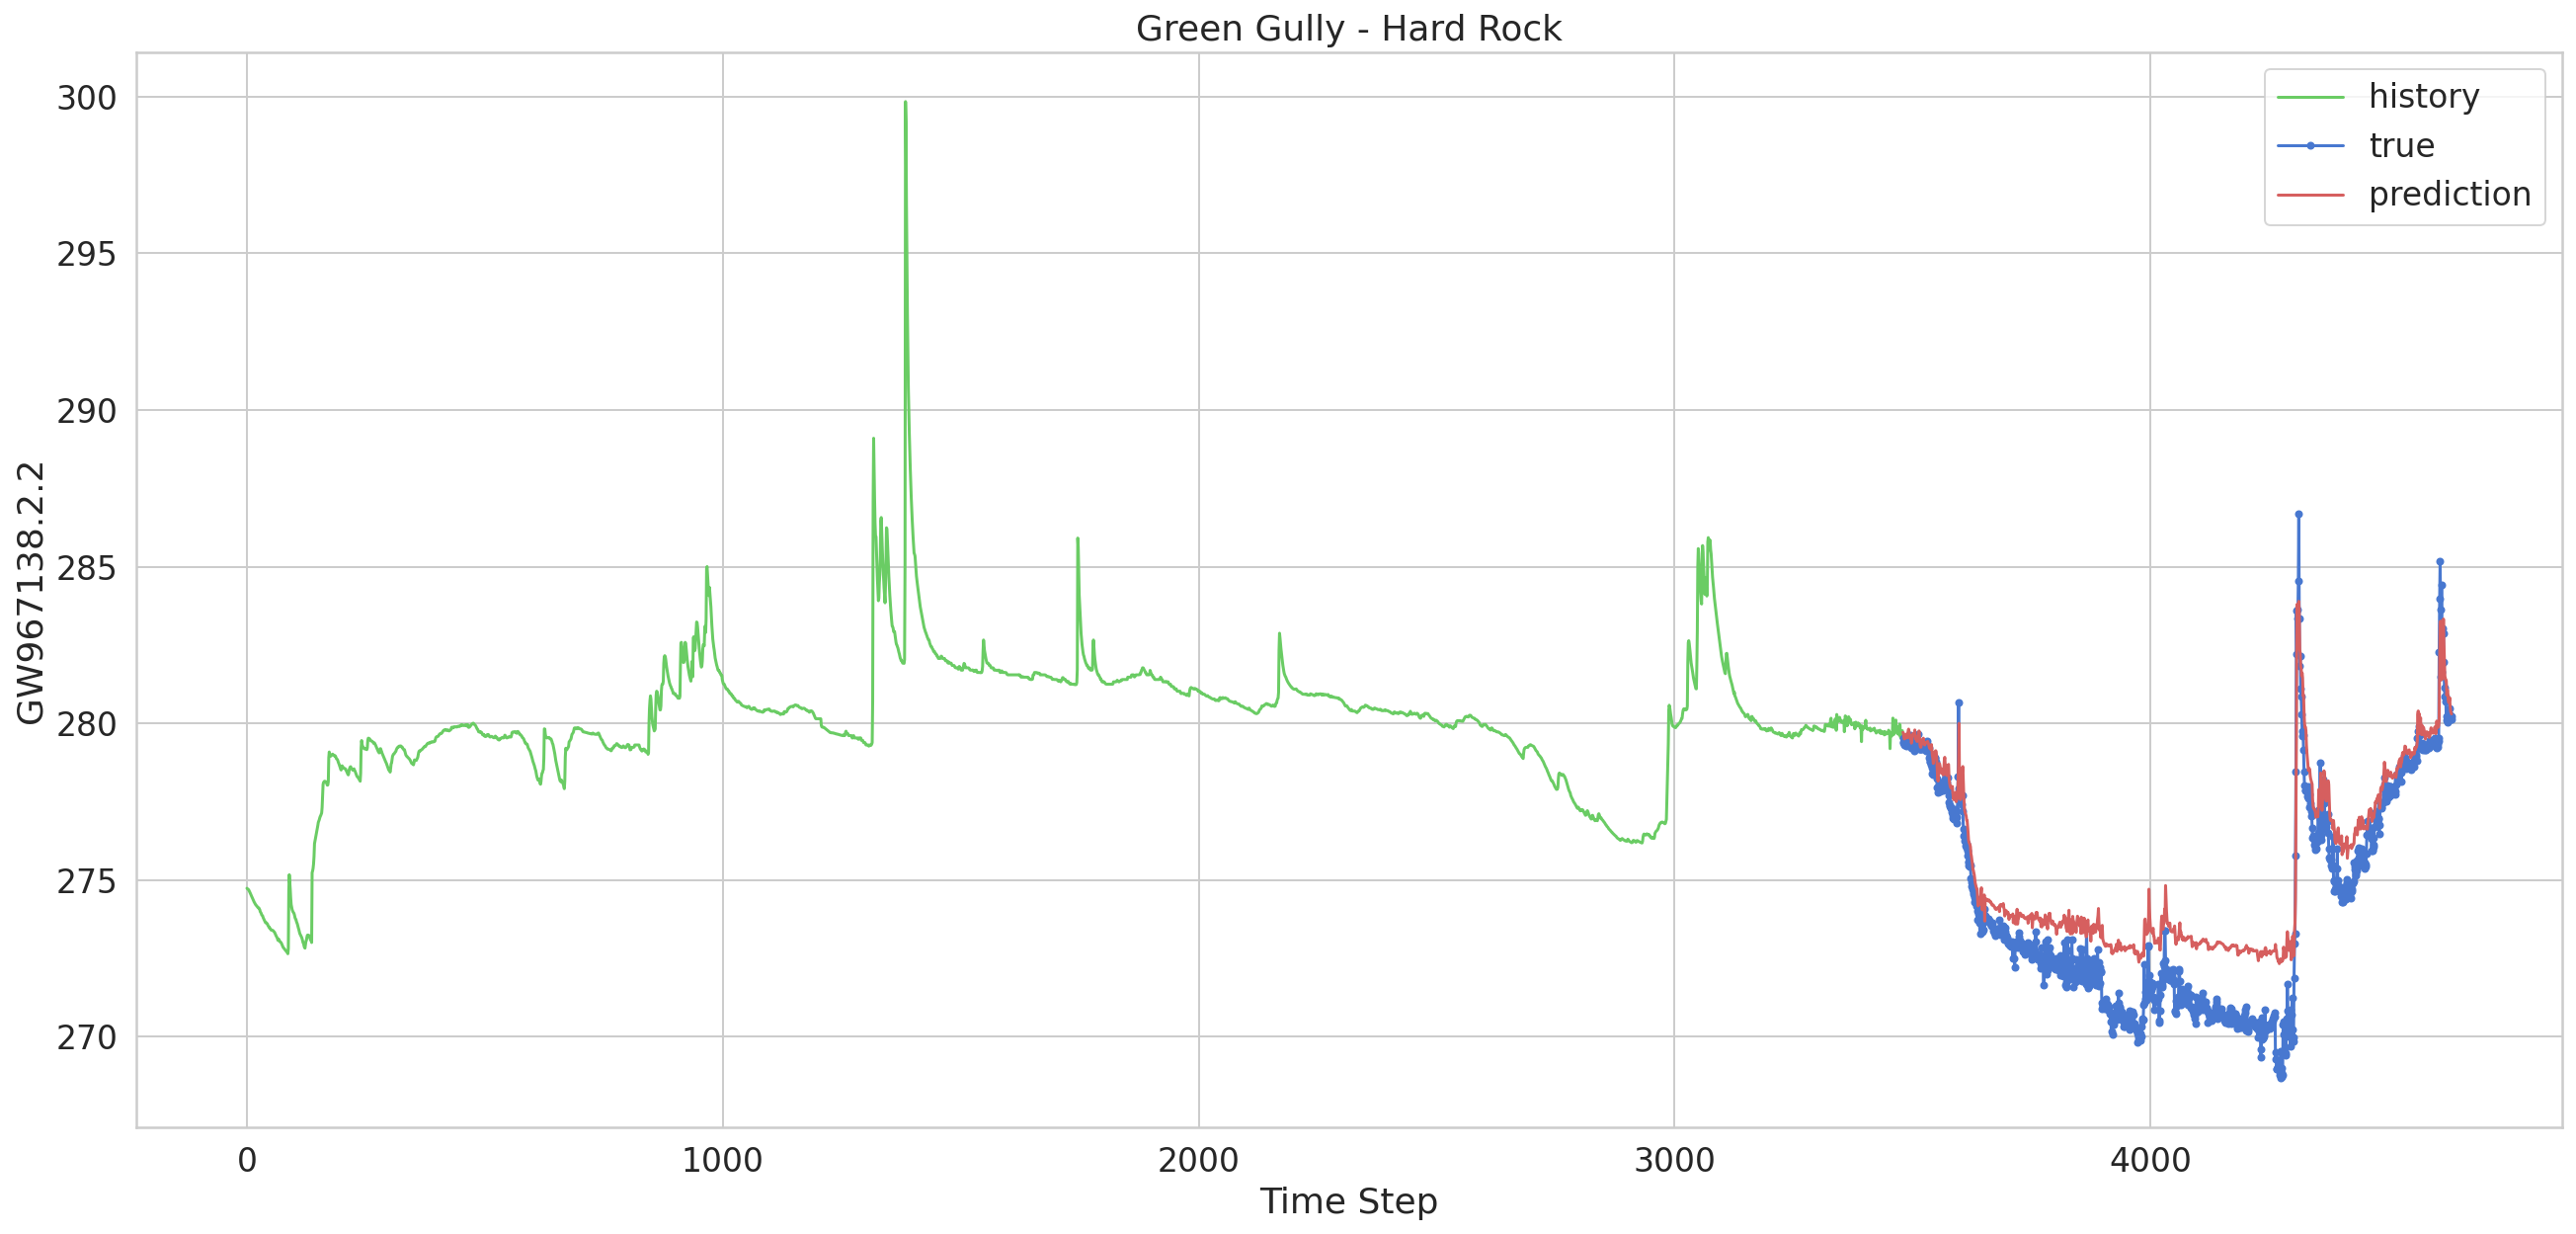

In [26]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('GW967138.2.2')
plt.xlabel('Time Step')
plt.title('Green Gully - Hard Rock')
plt.legend()
plt.show();

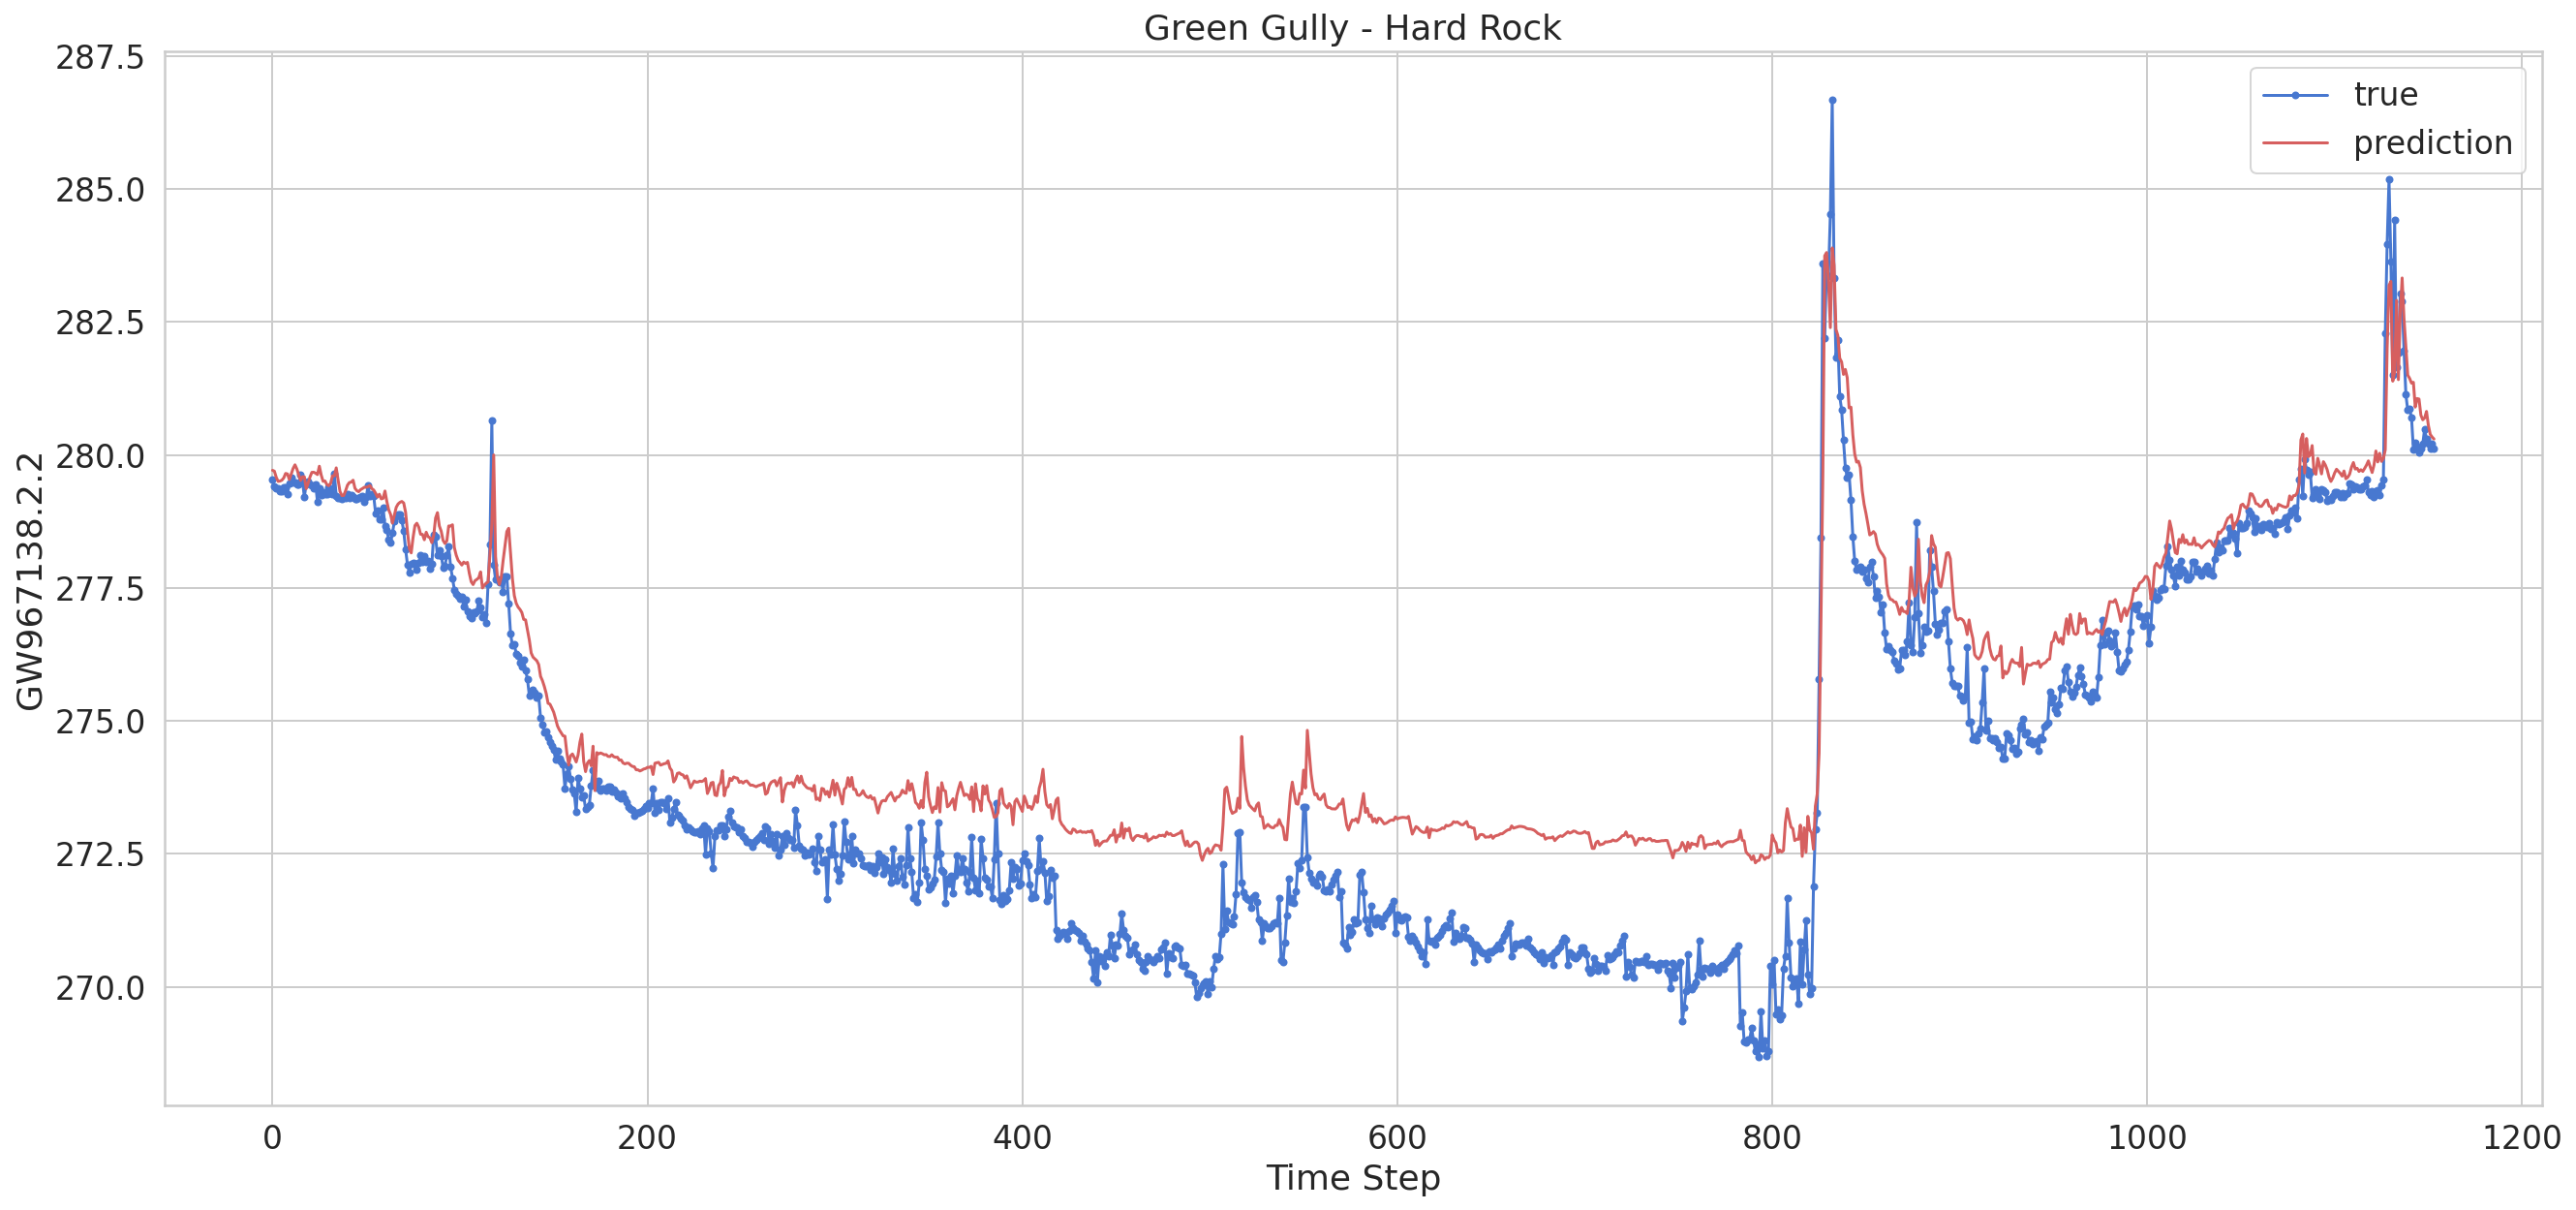

In [25]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('GW967138.2.2')
plt.xlabel('Time Step')
plt.title('Green Gully - Hard Rock')
plt.legend()
plt.show();

In [24]:
fname = '/home/jovyan/work/training_data/mhr2_modelled_training_data.csv'
np.savetxt(fname, y_pred_inv, fmt='%f', delimiter=' ', newline='\n', header='bl_ahd4', footer='', comments='', encoding=None)
